## Predicting Coronary Heart Disease

This tutorial will discuss how to build classification model and how to evaluate a model.

**Topics covered in this tutorial**

- Basic exploration of data before building models
- Encoding categorical features
- Splitting datasets into train and test datasets
- Build a Logistics Regression Model
- How logit funtion, log odds, odds and probabilities are related 
- How to find probabilities from the logistic model
- Find overall accuracy of the model
- Understand Confusion matrix
- Understand TPR, FPR, Precision, Recall, Sensitivity & Speficity 
- Understand ROC and how it is used 
- Find optimal Cutoff probability

Here is an intersting problem of understanding what factors contribute to CHD and can CHD be predicted by building an analytical model.

The next two sections will introduce some basics of CHD, where the dataset is derived from and what are the attributes available in the dataset.

### What is coronary heart disease?


[Coronary heart disease (CHD)](https://en.wikipedia.org/wiki/Coronary_artery_disease)  is when your coronary arteries (the arteries that supply your heart muscle with oxygen-rich blood) become narrowed by a gradual build-up of fatty material within their walls. These arteries can become narrowed through build-up of plaque, which is made up of cholesterol and other substances. Narrowed arteries can cause symptoms, such as chest pain (angina), shortness of breath, and fatigue.


### Dataset Description

Data is avaialable at: http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/
And header informtion is available at: http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/SAheart.info.txt

A retrospective sample of **males in a heart-disease high-risk region of the Western Cape, South Africa**. There are roughly two controls per case of CHD. Many of the CHD positive men have undergone blood pressure reduction treatment and other programs to reduce their risk factors after their CHD event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in Rousseauw et al, 1983, South African Medical Journal. 

### Import and load the dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
saheart_ds = pd.read_csv( "SAheart.data" )

In [3]:
saheart_ds.head()

row.names  sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  \
0          1  160    12.00  5.73      23.11  Present     49    25.30    97.20   
1          2  144     0.01  4.41      28.61   Absent     55    28.87     2.06   
2          3  118     0.08  3.48      32.28  Present     52    29.14     3.81   
3          4  170     7.50  6.41      38.03  Present     51    31.99    24.26   
4          5  134    13.60  3.50      27.78  Present     60    25.99    57.34   

   age  chd  
0   52    1  
1   63    1  
2   46    0  
3   58    1  
4   49    1

In [4]:
saheart_ds.columns

Index(['row.names', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea',
       'obesity', 'alcohol', 'age', 'chd'],
      dtype='object')

In [5]:
saheart_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 11 columns):
row.names    462 non-null int64
sbp          462 non-null int64
tobacco      462 non-null float64
ldl          462 non-null float64
adiposity    462 non-null float64
famhist      462 non-null object
typea        462 non-null int64
obesity      462 non-null float64
alcohol      462 non-null float64
age          462 non-null int64
chd          462 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 39.8+ KB


The class label int the column **chd** indicates if the person has a coronary heart disease: negative (0) or positive (1). 

Attributes description: 
- **sbp**:          systolic blood pressure 
- **tobacco**:      cumulative tobacco (kg) 
- **ldl**:          low densiity lipoprotein cholesterol 
- **adiposity**:    the size of the hips compared to the person's height 
- **famhist**:      family history of heart disease (Present, Absent) 
- **typea**:        type-A behavior 
- **obesity**:      BMI index
- **alcohol**:      current alcohol consumption 
- **age**:          age at onset

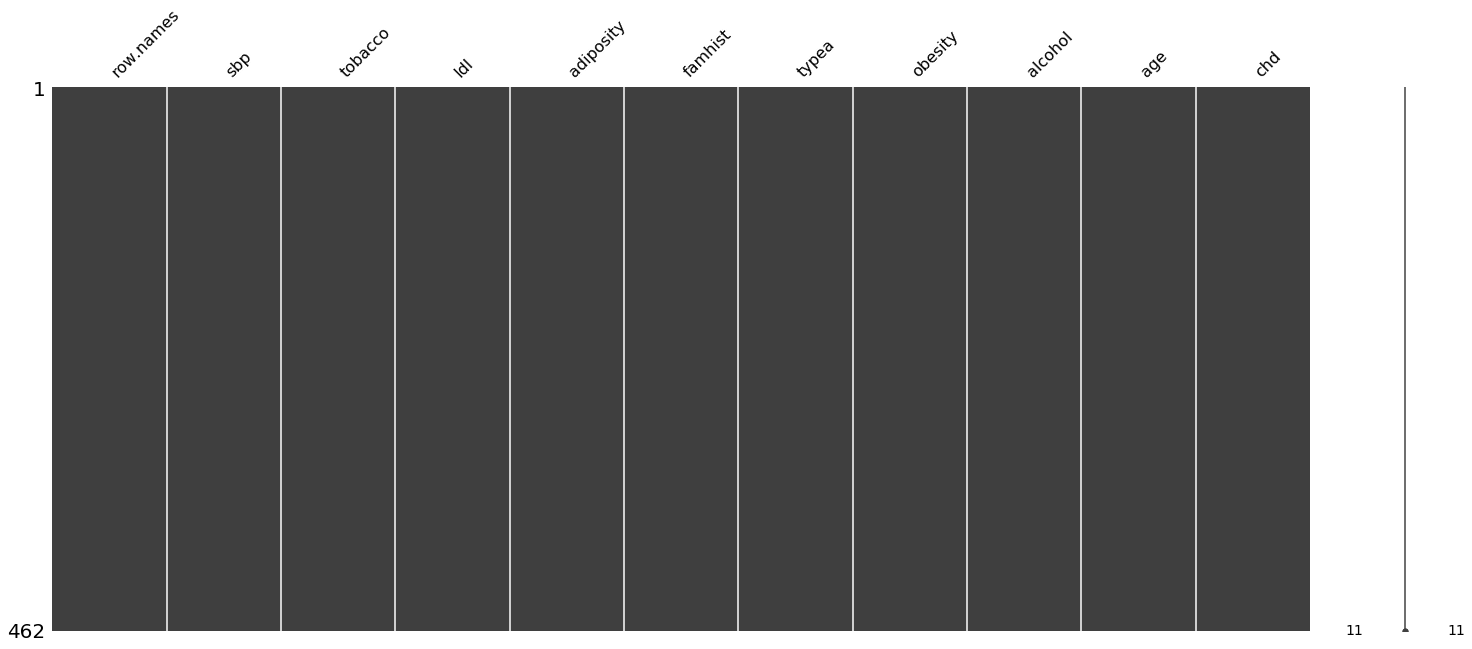

In [6]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

import missingno

missingno.matrix( saheart_ds )

There are no missing information. This is good news as we do not have to impute any data.  

## Exploratory Data Analysis

### Number of observations available for people with CHD and without CHD

In [7]:
saheart_ds.chd.value_counts()

0    302
1    160
Name: chd, dtype: int64

In [8]:
chd_df = pd.DataFrame( saheart_ds.chd.value_counts() )

In [9]:
chd_df

chd
0  302
1  160

In [10]:
chd_df['has_chd'] = chd_df.index
chd_df

chd  has_chd
0  302        0
1  160        1

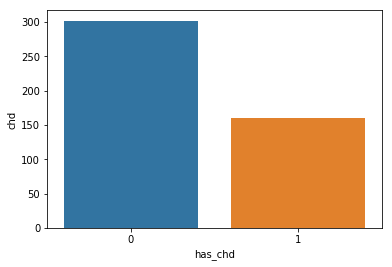

In [11]:
sn.barplot(  x = 'has_chd', y = 'chd', data = chd_df  )

In [12]:
famhist_chd = pd.crosstab( saheart_ds.famhist, saheart_ds.chd )
famhist_chd

chd        0   1
famhist         
Absent   206  64
Present   96  96

In [13]:
famhist_chd = famhist_chd.unstack().reset_index()
famhist_chd

chd  famhist    0
0    0   Absent  206
1    0  Present   96
2    1   Absent   64
3    1  Present   96

In [14]:
famhist_chd.columns = ['chd', 'famhist', 'total']

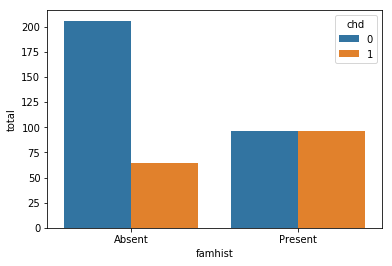

In [15]:
sn.barplot( famhist_chd.famhist, 
            famhist_chd.total, 
            hue = famhist_chd.chd )

#### Note: 

It can be observed that the chances of CHD for people having family history is higher compared to people with no famility history.

### How all the variable are inter-related?

We can draw a pair plot and understand the relationship between variables.

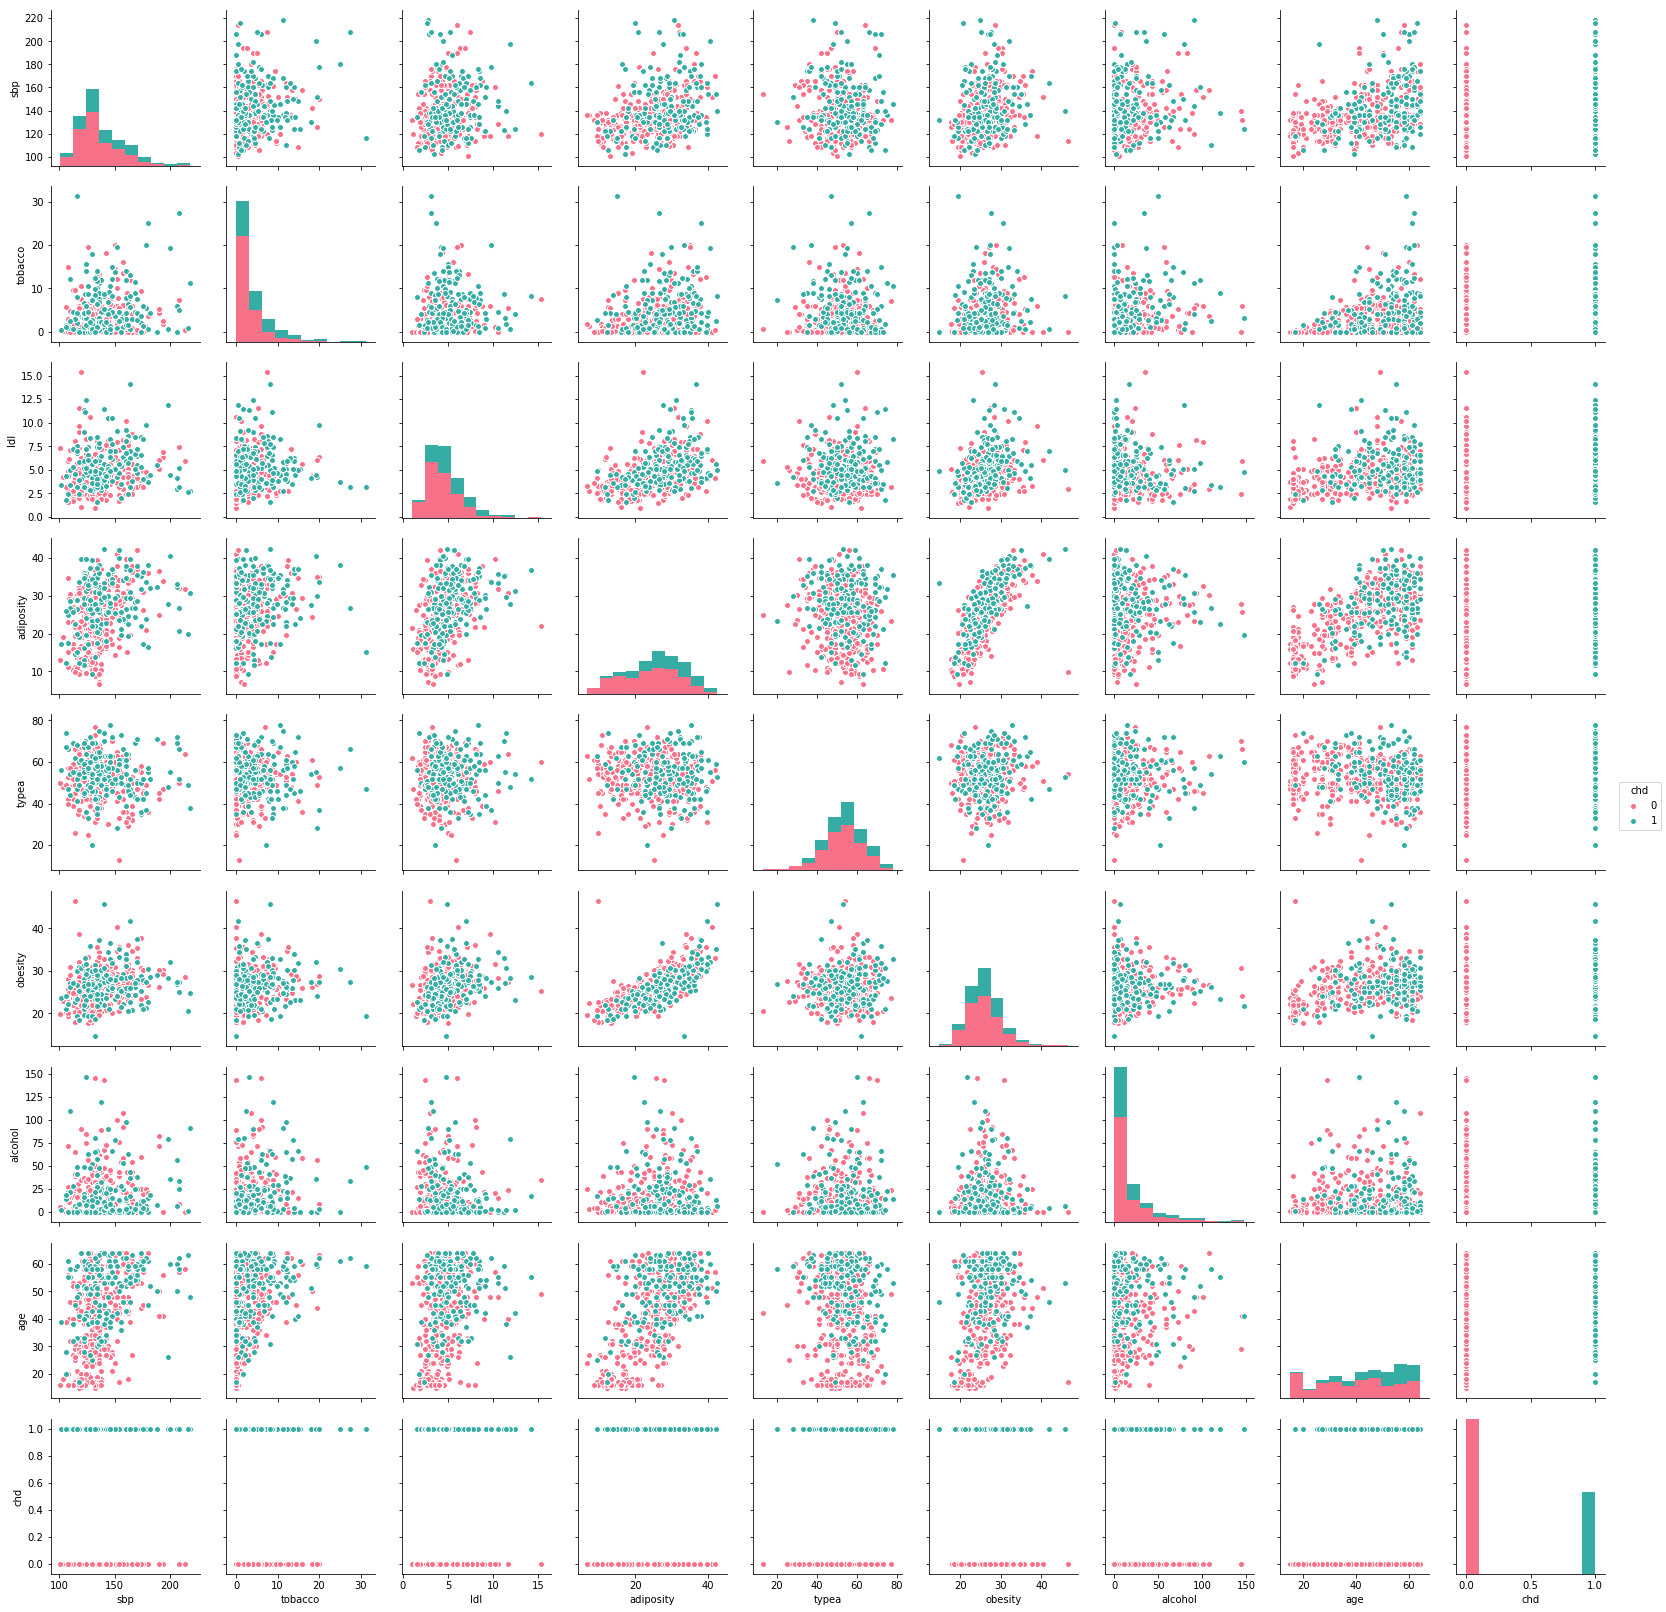

In [16]:
saheart_ds_sub = saheart_ds[['sbp', 'tobacco', 'ldl'
                         , 'adiposity', 'typea', 'obesity'
                         , 'alcohol', 'age', 'chd']]
sn.pairplot( saheart_ds_sub
           , hue = "chd"
           , palette="husl")

#### Note:

Few initial observations

* Obesity and adiposity are higly correlated
* Age and Adiposity is also correlated
* Older (aged) people are more prone to CHD
* higher spb + higher age has higher risk of CHD
* higher ldl + higher age increases the risk of CHD

Most of the above insights are very intuitive. But we can confirm with further analysis and hypothesis tests.

### What impact alcohol consumption has on CHD?

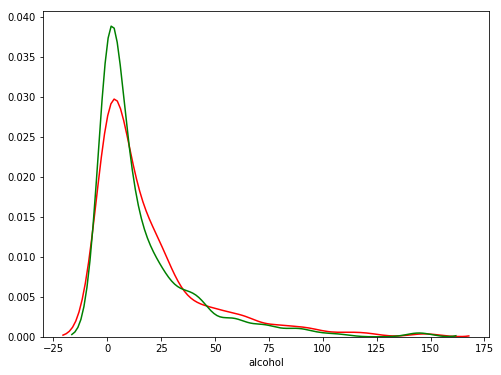

In [17]:
plt.figure(figsize=(8, 6))

sn.distplot( saheart_ds[ saheart_ds.chd == 1 ].alcohol,
            hist = False,
            color = 'r' )

sn.distplot( saheart_ds[ saheart_ds.chd == 0 ].alcohol,
            hist = False,
            color = 'g' )

#### Note:

Distribution of alcohol consumption for people with CHD and no CHD seems similar. We can verify this with a hypothesis test.

In [18]:
import scipy.stats as stats

In [19]:
stats.ttest_ind( saheart_ds[ saheart_ds.chd == 0 ].alcohol, 
                 saheart_ds[ saheart_ds.chd == 1 ].alcohol )

Ttest_indResult(statistic=-1.3437633510233433, pvalue=0.1796873576620041)

#### Note:

Average achohol consumption of people with CHD and NO CHD are same. So, achohol consumption may be a non significant factor in determining or predicting CHD.

### What impact tobacco consumption has on CHD?

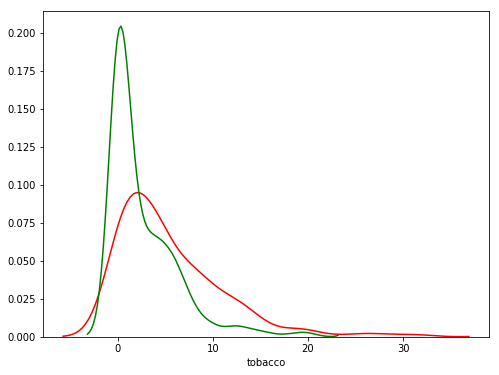

In [20]:
plt.figure(figsize=(8, 6))

sn.distplot( saheart_ds[ saheart_ds.chd == 1 ].tobacco,
            hist = False,
            color = 'r' )

sn.distplot( saheart_ds[ saheart_ds.chd == 0 ].tobacco,
            hist = False,
            color = 'g' )

In [21]:
stats.ttest_ind( saheart_ds[ saheart_ds.chd == 0 ].tobacco, 
                 saheart_ds[ saheart_ds.chd == 1 ].tobacco )

Ttest_indResult(statistic=-6.737983717964519, pvalue=4.815842571605575e-11)

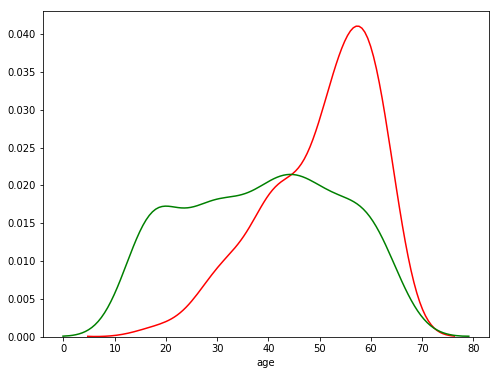

In [22]:
plt.figure(figsize=(8, 6))

sn.distplot( saheart_ds[ saheart_ds.chd == 1 ].age,
            hist = False,
            color = 'r' )

sn.distplot( saheart_ds[ saheart_ds.chd == 0 ].age,
            hist = False,
            color = 'g' )

In [23]:
stats.ttest_ind( saheart_ds[ saheart_ds.chd == 0 ].age, 
                 saheart_ds[ saheart_ds.chd == 1 ].age )

Ttest_indResult(statistic=-8.621496303728742, pvalue=1.0741818171806074e-16)

#### Note: 

The patterns of Tobacco consumption and age are different for people with CHD and no CHD. So, these two may be significant factors.

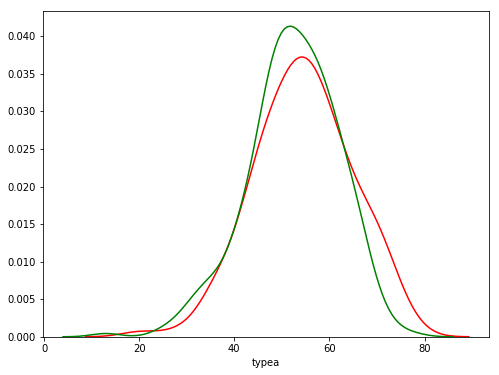

In [24]:
plt.figure(figsize=(8, 6))

sn.distplot( saheart_ds[ saheart_ds.chd == 1 ].typea,
            hist = False,
            color = 'r' )

sn.distplot( saheart_ds[ saheart_ds.chd == 0 ].typea,
            hist = False,
            color = 'g' )

### Predict CHD using only age

In [25]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

In [26]:
from sklearn.cross_validation import train_test_split

/Users/manaranjan/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
feature_cols = ['age']

saheart_train_X, saheart_test_X,  \
saheart_train_Y, saheart_test_Y = train_test_split( saheart_ds[feature_cols],
                                                    saheart_ds['chd'],
                                                    test_size = 0.3,
                                                    random_state = 42 ) 

logreg.fit( saheart_train_X, saheart_train_Y )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
list( zip( feature_cols, logreg.coef_[0] ) )

[('age', 0.04985780783001598)]

In [29]:
logreg.intercept_

array([-2.82950924])

The logit function can be written as 

$$ln(odd)=\beta _{0}+\beta _{1}x$$ 


So, the logit function of this model can be written as 

** -3.05632794 + 0.0549547 * age **

Logit function is nothing but the log of odds, so the odds can be expressed in terms of logit function as 

$$odd = e^{(\beta _{0}+\beta _{1}x)} $$


Odds can be defined as the probability of one event will happen with respect to the probability of that event will not happen. And mathmatically it is described as 

$$odd = ({\frac {p}{1-p}})$$

So, probabilties can be computed from odds as 

$${\frac {e^{\beta _{0}+\beta _{1}x}}{1+e^{\beta _{0}+\beta _{1}x}}  }$$

### Encoding categorical features

In [41]:
saheart_model_df = pd.get_dummies( saheart_ds, 
                                   columns = ['famhist'],
                                   drop_first = True)

In [42]:
saheart_model_df.head( 10 )

row.names  sbp  tobacco   ldl  adiposity  typea  obesity  alcohol  age  \
0          1  160    12.00  5.73      23.11     49    25.30    97.20   52   
1          2  144     0.01  4.41      28.61     55    28.87     2.06   63   
2          3  118     0.08  3.48      32.28     52    29.14     3.81   46   
3          4  170     7.50  6.41      38.03     51    31.99    24.26   58   
4          5  134    13.60  3.50      27.78     60    25.99    57.34   49   
5          6  132     6.20  6.47      36.21     62    30.77    14.14   45   
6          7  142     4.05  3.38      16.20     59    20.81     2.62   38   
7          8  114     4.08  4.59      14.60     62    23.11     6.72   58   
8          9  114     0.00  3.83      19.40     49    24.86     2.49   29   
9         10  132     0.00  5.80      30.96     69    30.11     0.00   53   

   chd  famhist_Present  
0    1                1  
1    1                0  
2    0                1  
3    1                1  
4    1                1  
5    0                1  
6    0                0  
7    1                1  
8    0                1  
9    1                1

In [48]:
saheart_model_df = saheart_model_df.drop( "row.names", axis = 1 )

In [49]:
saheart_model_df.columns

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol',
       'age', 'chd', 'famhist_Present'],
      dtype='object')

## Splitting Dataset into Train and Test

In [50]:
from sklearn.cross_validation import train_test_split


feature_cols = ['sbp', 'tobacco', 'ldl', 
                'adiposity', 'typea', 
                'obesity', 'alcohol', 
                'age', 'famhist_Present' ]

saheart_train_X, saheart_test_X,  \
saheart_train_Y, saheart_test_Y = train_test_split( saheart_model_df[feature_cols],
                                                   saheart_model_df['chd'],
                                                   test_size = 0.3,
                                                  random_state = 42 ) 

In [51]:
len( saheart_train_X )

323

In [52]:
len( saheart_test_X )

139

## Building Logistic Regression Model

In [53]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

In [54]:
logreg.fit( saheart_train_X, saheart_train_Y )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Estimated Model Parameters

In [55]:
list( zip( feature_cols, logreg.coef_[0] ) )

[('sbp', 0.000504963210205059),
 ('tobacco', 0.06692837320641304),
 ('ldl', 0.19220393873757705),
 ('adiposity', 0.05808427368121722),
 ('typea', 0.014810827015736919),
 ('obesity', -0.1427734508788726),
 ('alcohol', 0.0014097699816536875),
 ('age', 0.02679438672459535),
 ('famhist_Present', 0.7029143392492767)]

In [56]:
logreg.intercept_

array([-1.99614093])

In [57]:
len( saheart_test_X )

139

### Predicting in test set using the model

In [54]:
saheart_test_results = pd.DataFrame( { 'actual':  saheart_test_Y, 
                                     'predicted': logreg.predict( saheart_test_X ) } )

In [55]:
saheart_test_results = saheart_test_results.reset_index()
saheart_test_results.head()

index  actual  predicted
0    225       0          0
1     30       1          0
2     39       1          1
3    222       0          1
4    124       0          0

## Model Evaluation

### Confusion Matrix

In [56]:
from sklearn import metrics

cm = metrics.confusion_matrix( saheart_test_results.actual, 
                              saheart_test_results.predicted, [1,0] )
cm

array([[25, 24],
       [11, 79]])

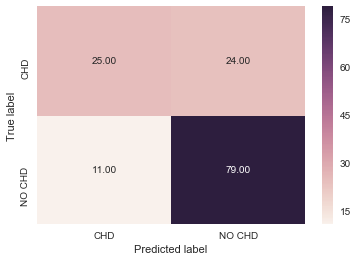

In [57]:
sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["CHD", "NO CHD"] , yticklabels = ["CHD", "NO CHD"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

### How good is the model?

How good a model can predict can be determined by few matrices. *TPR, precision, recall, sesitivity, specificity, accuracy score, ROC curve* are few of those and we will discuss one by one.

- *TPR - True Positive Rate*
- *ROC - Receiver Operating Curve*

The confusion matrix show actual vs. predicted values. Actuals are depicted as row wise values where as predicted values are depicted as the column-wise values.

In this example, 0 mean NO-CHD and 1 mean CHD. The true/false positives/negatives are defined as below.

![Confusion Matrix](Classification_Matrix.png)


**Precision** is defined as how many are actual positives out of total number of positives identified by the model and is defined as 

$$TPR = ({\frac {TP}{TP+FP}})$$

**True Positive Rate (TPR) or Recall or Sensitivity** is how many actual positive are properly identified by the model out of total number actual positive in the test set and is defined as 

$$TPR = ({\frac {TP}{TP+FN}})$$

**True Negative Rate (TNR) or Specificity** is how many are correctly indentified as correct negatives out of all acutal negative present in the test set and is defined as 

$$TNR = ({\frac {TN}{FP+TN}})$$

A good model should have higher true positives and true negatives i.e. higher TPR and TNR. 

But in real world it is not possible. Primarily because of either the dataset or models not able to differentiate well between positives and negatives. So, there is always a trade-off. How well the model is able to differentiate between positve and negatives determine how good the model is.

This can be understood by first plotting the probability distributions by the model for different classes. Let's plot and understand this aspect of this model.

### Overall Accuracy

Overall accuracy of the model is given by how many true positive and true negatives were correctly identified by the model and is given by


$$ Accuracy Score = ({\frac {TP + TN}{ TP + FP + TN + FN }})$$

In [58]:
score = metrics.accuracy_score( saheart_test_results.actual, saheart_test_results.predicted )
round( float(score), 2 )

0.75